This notebook takes ~2.5 minutes to run.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_X_z = pd.read_parquet('./../data/df_X_z_v1.parquet')
df_y_z = pd.read_parquet('./../data/df_y_z_v1.parquet')

In [3]:
import pickle
with open("./../models/StandardScalers.pkl", "rb") as f:
    data = pickle.load(f)
SS_y = data["SS_y"]

In [4]:
X_wo = df_X_z.loc[df_y_z["score"].isna(),:].to_numpy(dtype="float32")
X = df_X_z.loc[df_y_z["score"].notna(),:].to_numpy(dtype="float32")
y = df_y_z.loc[df_y_z["score"].notna(),"score"].to_numpy(dtype="float32")

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=0)

# Predict Metacritic scores of games without one
### Design
There 3910 games with a score. Let's reserve 0.15 of it for final testing. The rest will be used in cross validation to find the best model + hyperparameters. The final testing performance, as well as the confidence tiers will help us in interpreting the predicted scores.
### Models
1. linear regression: tune regularization strength and l1 ratio.
2. XGBoost: 
3. Multilayer perceptron: 

## Model 1: Elastic Net

#### Step 1: Tuning hyperparameters

In [6]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import ElasticNetCV
%matplotlib inline
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
regr = ElasticNetCV(
    l1_ratio = l1_ratio,
    alphas = 100,
    cv=5, 
    max_iter=1000,
    random_state=0,
    n_jobs=-1)
regr.fit(X_train, y_train)
MSE_train = regr.mse_path_.mean(axis=2)

#### Step 2: Picking hyperparameters
It looks like small alpha (weak regularization) gives the best MSE, meaning that our features have limited predicting power (given the number of observations).

Let's choose `l1_ratio=1`, i.e. lasso only, for straightforward interpretability of feature importance.

Text(0.5, 1.0, 'ElasticNetCV path')

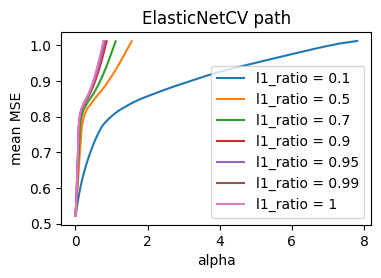

In [7]:
# plot MSE 
plt.figure(figsize=(4, 2.5))
plt.plot(regr.alphas_.T, MSE_train.T,label=[("l1_ratio = " + str(p)) for p in l1_ratio])
plt.xlabel("alpha")
plt.ylabel("mean MSE")
plt.legend()
plt.title("ElasticNetCV path")

In [8]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
print(f"Best Elastic net alpha = {regr.alpha_}")
print(f"Best Elastic net l1_ratio = {regr.l1_ratio_}")

best_EN = ElasticNet(
    alpha=regr.alpha_,
    l1_ratio=regr.l1_ratio_, 
    random_state=0)

y_pred_cv = cross_val_predict(best_EN,X_train,y_train,
    cv=KFold(n_splits=5, random_state=1, shuffle=True))
print(f"Best Elastic net MSE = {MSE(y_train,y_pred_cv)}")

Best Elastic net alpha = 0.0025572272442353963
Best Elastic net l1_ratio = 1.0
Best Elastic net MSE = 0.5248199105262756


Text(0.5, 1.0, 'ElasticNet best model training error distribution')

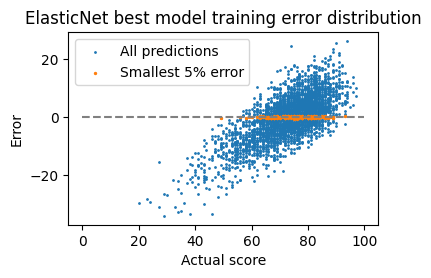

In [9]:
def scatter_error(y_pred_test,y_train,SS_y):
    # visualize error as a function of original value
    df_y_inverted = pd.DataFrame(
        SS_y.inverse_transform(np.stack((y_train,y_pred_test),axis=1)),
        columns=["y_orig","y_pred"])
    
    fig = plt.figure(figsize=(4, 2.5))
    
    plt.plot([0, 100], [0, 0], "--", color="gray", label=None,figure=fig)
    
    df_plot = (pd.DataFrame({"y_orig": df_y_inverted["y_orig"],
        "error": df_y_inverted.iloc[:, 0] - df_y_inverted.iloc[:, 1],}).sort_values(by="y_orig"))
    
    # threshold for smallest 5% error
    thr = df_plot["error"].abs().quantile(0.05)
    
    # remaining 95% (default blue)
    plt.scatter(df_plot["y_orig"], df_plot["error"],
        s=1,label="All predictions",figure=fig)
    
    # smallest 5% error (next default color = orange)
    plt.scatter(
        df_plot.loc[df_plot["error"].abs() <= thr, "y_orig"],
        df_plot.loc[df_plot["error"].abs() <= thr, "error"],
        s=2,label="Smallest 5% error",figure=fig)
    
    fig.gca().legend()
    
    plt.xlabel("Actual score",figure=fig)
    plt.ylabel("Error",figure=fig)
    return fig
fig = scatter_error(y_pred_cv,y_train,SS_y)
plt.title("ElasticNet best model training error distribution",figure=fig)

In [10]:
# fit best ElasticNet model on all training data
best_EN.fit(X_train,y_train)

df_feat_coef = pd.DataFrame({"feature name":df_X_z.columns,"coef": best_EN.coef_,"absolute coef": np.abs(best_EN.coef_)}
                           ).sort_values("absolute coef",ascending=False)
df_feat_coef.head(10)

,feature name,coef,absolute coef
17,positive_log1p,1.008329,1.008329
13,negative_log1p,-0.856672,0.856672
18,price_is0,0.504288,0.504288
16,positive_is0,0.434383,0.434383
125,reviews_notna,0.240511,0.240511
122,support_email_notna,-0.192664,0.192664
19,price_log1p,0.136625,0.136625
129,movies_notna,-0.134213,0.134213
73,SVD_tags_5,-0.112473,0.112473
21,recommendations_log1p,0.100633,0.100633


### Elastic net summary
Best parameters are 
- alpha=0.0025 (very weak regularization)
- l1 ratio=1 (lasso only)
  
Cross validation MSE is 0.5248. Predictions are most accurate for scores in the 70-80 range.

## Model 2: XGBoost regression

#### Step 1: Tuning hyperparameters

In [11]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

base = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mse",
    tree_method="hist",
    random_state=0,
    n_jobs=-1,
)

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.01, 0.03],
    "reg_alpha": [0.01,0.1,1,10],
    "reg_lambda": [0.01,0.1,1,10],
    'subsample': [0.3, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'max_depth': [3,5,7],
    'min_child_weight':[10,20,40]
}
    
kf = KFold(n_splits=5, random_state=0, shuffle=True)

GSCV = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    cv=kf,
    verbose=2,
    return_train_score=True,
    error_score="raise",
    scoring='neg_mean_squared_error'
)

# GSCV.fit(X_train, y_train)

# ------------- this is a very extensive search ------------- 
# ------------- it took around 4 hours to run ------------- 
# ------------- do not rerun. load data instead ------------- 


with open('./../models/GSCV_XGBRegressor_v3.pkl','rb') as f:
    data = pickle.load(f)
GSCV = data["GSCV"]
param_grid = data["param_grid"]
best_XGBR = data["best_XGBR"]


#### Step 2: Picking hyperparameters
`mean_test_score` and `mean_train_score` are negative mean squared error, so smaller absolute value is better performance.

Top 10 best models all have
```
colsample_bytree=0.7
learning_rate=0.03
max_depth=7
n_estimators=200
subsample=0.7
```

the most flexible params in the grid, suggesting that the model is variance limited. 

However, the training errors are a lot smaller than validation errors (see table and plot), suggesting overfitting.

Truly perfect generalization where train and val errors are comparable was not attained in tuning (see plot), suggesting the features are not informative enough.

I included regularizing params (`alpha`, `lambda`, `min_child_weight`) to help the model learn the true pattern without being too complex. But they don't seem to matter because the top performing models had any values in the grid for these params.

Given the confusing findings, plus the fact that **the best XGB model had worse CV MSE (0.5464) than the ElasticNet model (0.5248)**, I decided to pick the most regularized model out of the top 10 and move on to the next step.

In [12]:
GSCV_results = pd.DataFrame(GSCV.cv_results_).drop(columns=["params"]).sort_values('rank_test_score')
GSCV_results.columns = (GSCV_results.columns.str.removeprefix("param_"))
pd.set_option('display.max_columns', None)
GSCV_results[['colsample_bytree','learning_rate','max_depth','min_child_weight','n_estimators',
              'reg_alpha','reg_lambda','subsample','mean_test_score','mean_train_score']].head(10)
# GSCV_results.head(10)

,colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,mean_test_score,mean_train_score
5054,0.7,0.03,7,20,200,0.10,0.01,0.7,-0.525924,-0.149252
5045,0.7,0.03,7,20,200,0.01,0.10,0.7,-0.526743,-0.149707
5057,0.7,0.03,7,20,200,0.10,0.10,0.7,-0.526856,-0.148995
5048,0.7,0.03,7,20,200,0.01,1.00,0.7,-0.527344,-0.152172
5042,0.7,0.03,7,20,200,0.01,0.01,0.7,-0.528121,-0.150120
5060,0.7,0.03,7,20,200,0.10,1.00,0.7,-0.529410,-0.151139
5141,0.7,0.03,7,40,200,0.01,0.10,0.7,-0.531979,-0.231034
5150,0.7,0.03,7,40,200,0.10,0.01,0.7,-0.532227,-0.230291
5153,0.7,0.03,7,40,200,0.10,0.10,0.7,-0.532573,-0.229995
5066,0.7,0.03,7,20,200,1.00,0.01,0.7,-0.532659,-0.149337


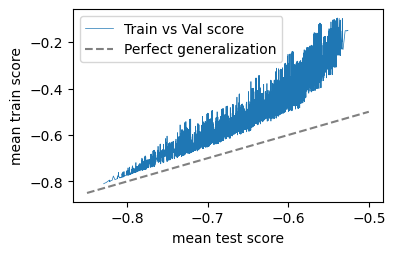

In [13]:
plt.figure(figsize=(4,2.5))
plt.plot("mean_test_score","mean_train_score",data=GSCV_results,
         label="Train vs Val score",lw=0.5)
plt.plot([-0.85, -0.5], [-0.85, -0.5], "--", color="gray", label="Perfect generalization")
plt.xlabel("mean test score")
plt.ylabel("mean train score")
plt.legend()

#### Step 3: Check cross-validation performance

Best XGBRegressor MSE = 0.5463785529136658
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.03, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 40, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


Text(0.5, 1.0, 'XGBRegression best model training error distribution')

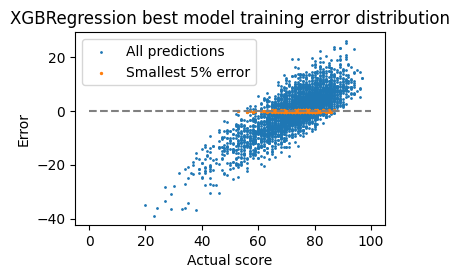

In [14]:
best_XGBR = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=0,
    n_jobs=-1,
    colsample_bytree=0.7,
    learning_rate=0.03,
    max_depth=7,
    min_child_weight=40,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.7
)
    
y_pred_cv = cross_val_predict(best_XGBR,X_train,y_train,
    cv=KFold(n_splits=5, random_state=1, shuffle=True))
print(f"Best XGBRegressor MSE = {MSE(y_train,y_pred_cv)}")
print(best_XGBR.get_params())

fig = scatter_error(y_pred_cv,y_train,SS_y)
plt.title("XGBRegression best model training error distribution",figure=fig)

In [15]:
# fit best XGBoost regression model on all training data
best_XGBR.fit(X_train,y_train)

df_feat_im = pd.DataFrame({"feature_name":df_X_z.columns,"importance":best_XGBR.feature_importances_}
                         ).sort_values("importance",ascending=False)
df_feat_im.head(10)

,feature_name,importance
15,peak_ccu_log1p,0.066388
17,positive_log1p,0.033633
14,peak_ccu_is0,0.029314
21,recommendations_log1p,0.020540
13,negative_log1p,0.020391
125,reviews_notna,0.018143
70,SVD_tags_2,0.015455
71,SVD_tags_3,0.013887
34,SVD_categories_6,0.012373
75,SVD_tags_7,0.012058


In [16]:
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


DEVICE = torch.device("cpu")
EPOCHS = 20

# split 1/5 data for tuning validation
X_train_train, X_val, y_train_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

dataset_train = TensorDataset(torch.as_tensor(X_train_train, dtype=torch.float32), 
                              torch.as_tensor(y_train_train, dtype=torch.float32))
dataset_val = TensorDataset(torch.as_tensor(X_val, dtype=torch.float32), 
                            torch.as_tensor(y_val, dtype=torch.float32))


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 4)
    layers = []

    in_features = 137
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
        
    layers.append(nn.Linear(in_features, 1))

    return nn.Sequential(*layers)

def objective(trial):
    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RMSprop", "SGD"])

    weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-2, log=True)
    
    if optimizer_name == "AdamW":
        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    elif optimizer_name == "RMSprop":
        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        alpha = trial.suggest_float("rmsprop_alpha", 0.85, 0.99)
        momentum = trial.suggest_float("rmsprop_momentum", 0.0, 0.95)
        optimizer = optim.RMSprop(
            model.parameters(), lr=lr, alpha=alpha, momentum=momentum, weight_decay=weight_decay)
    
    elif optimizer_name == "SGD":
        lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
        momentum = trial.suggest_float("momentum", 0.0, 0.95)
        nesterov = trial.suggest_categorical("nesterov", [False, True]) if momentum > 0 else False
        optimizer = optim.SGD(
            model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov, weight_decay=weight_decay)

    # Get the data
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    train_loader = DataLoader(dataset_train,batch_size=batch_size,
        shuffle=True,drop_last=False)
    val_loader = DataLoader(dataset_val,batch_size=batch_size,
        shuffle=True,drop_last=False)

    # Training of the model.
    train_MSE = []
    val_MSE = []
    for epoch in range(EPOCHS):
        train_loss = 0.0
        train_n = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad()
            output = model(data).squeeze(-1)
            loss = F.mse_loss(output, target)
            train_loss += F.mse_loss(output, target,reduction="sum").item()
            train_n += target.numel()
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        val_loss = 0.0
        val_n = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):

                output = model(data).squeeze(-1)
                val_loss += F.mse_loss(output, target,reduction="sum").item()
                val_n += target.numel()

        mean_loss = val_loss / val_n
        
        train_MSE.append(train_loss/train_n)
        val_MSE.append(val_loss/val_n)        

        trial.report(mean_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            trial.set_user_attr("train_MSE", train_MSE)
            trial.set_user_attr("val_MSE", val_MSE)
            trial.set_user_attr("epochs",epoch+1)
            raise optuna.exceptions.TrialPruned()

    trial.set_user_attr("train_MSE", train_MSE)
    trial.set_user_attr("val_MSE", val_MSE)
    trial.set_user_attr("epochs",EPOCHS)
    return mean_loss





study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, timeout=1200)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-18 15:46:14,285] A new study created in memory with name: no-name-54cf012c-85ab-469e-8988-e2a947e70d62
[I 2026-01-18 15:46:19,245] Trial 0 finished with value: 0.7155584550441656 and parameters: {'n_layers': 3, 'n_units_l0': 109, 'dropout_l0': 0.4863259815771802, 'n_units_l1': 119, 'dropout_l1': 0.37345780906650494, 'n_units_l2': 119, 'dropout_l2': 0.12942063006630194, 'optimizer': 'AdamW', 'weight_decay': 0.003940044134873714, 'lr': 4.75188912722718e-05, 'batch_size': 64}. Best is trial 0 with value: 0.7155584550441656.
[I 2026-01-18 15:46:22,846] Trial 1 finished with value: 0.7120625660831766 and parameters: {'n_layers': 3, 'n_units_l0': 171, 'dropout_l0': 0.1920000361225586, 'n_units_l1': 131, 'dropout_l1': 0.41817363176058797, 'n_units_l2': 28, 'dropout_l2': 0.1286089948729229, 'optimizer': 'SGD', 'weight_decay': 0.00015401428933241768, 'lr': 0.014253720614764294, 'momentum': 0.5231217347993864, 'nesterov': False, 'batch_size': 32}. Best is trial 1 with value: 0.7120625

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  77
  Number of complete trials:  23
Best trial:
  Value:  0.5372957516433601
  Params: 
    n_layers: 2
    n_units_l0: 132
    dropout_l0: 0.14053213370624987
    n_units_l1: 37
    dropout_l1: 0.17923909787816233
    optimizer: SGD
    weight_decay: 2.565699061262778e-06
    lr: 0.003319853285215946
    momentum: 0.8809250800563369
    nesterov: True
    batch_size: 32


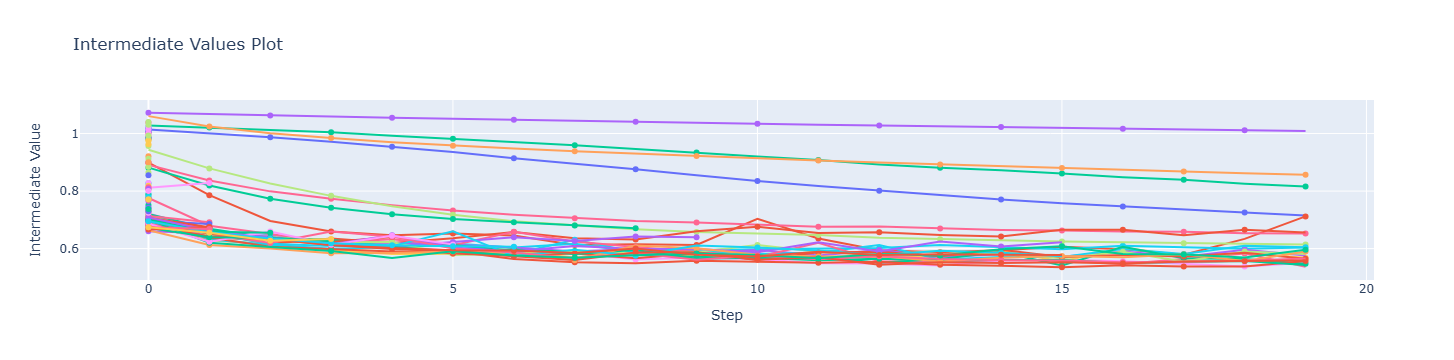

In [17]:
optuna.visualization.plot_intermediate_values(study)

#### Step 2: Picking hyperparameters
The floor of validation performance is very clear in the plot above. 

Let's take the best param and retrain the model on full CV.

After retraining, I found that **the best MLP had worse CV MSE (0.6364) than both the XGB and the EN regressors**.

Text(0.5, 1.0, 'Best trial MSE over epochs')

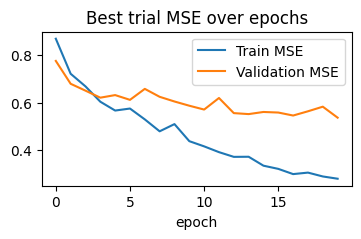

In [18]:
plt.figure(figsize=(4,2))
plt.plot(trial.user_attrs["train_MSE"],label="Train MSE")
plt.plot(trial.user_attrs["val_MSE"],label="Validation MSE")
plt.xlabel("epoch")
plt.legend()
plt.title("Best trial MSE over epochs")

Best MLP MSE = 0.6071754097938538


Text(0.5, 1.0, 'MLP best model training error distribution')

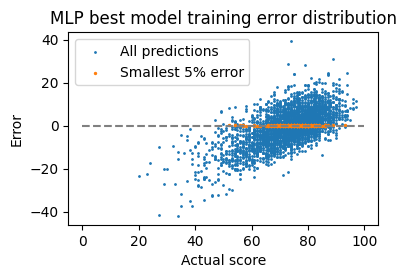

In [19]:
# build MLP with best params
best = study.best_params
def build_best_MLP_optimizer(best):
    layers = []
    in_features = 137
    out_features = best["n_units_l0"]
    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(best["dropout_l0"]))
    in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    best_MLP = nn.Sequential(*layers)

    if best["optimizer"] == "AdamW":
        best_optimizer = optim.AdamW(
            best_MLP.parameters(), lr=best["lr"], weight_decay=best["weight_decay"])
        
    elif best["optimizer"] == "RMSprop":
        best_optimizer = optim.RMSprop(
            best_MLP.parameters(), lr=best["lr"], alpha=best["rmsprop_alpha"], 
            momentum=best["rmsprop_momentum"], weight_decay=best["weight_decay"])
    
    elif best["optimizer"] == "SGD":
        best_optimizer = optim.SGD(
            best_MLP.parameters(), lr=best["lr"], momentum=best["momentum"], 
            nesterov=best["nesterov"], weight_decay=best["weight_decay"])
    return best_MLP, best_optimizer
    
best_MLP, best_optimizer = build_best_MLP_optimizer(best)

# get cross val prediction the same way as other models
y_pred_cv = np.zeros_like(y_train)
kf = KFold(n_splits=5, random_state=1, shuffle=True)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    best_MLP, best_optimizer = build_best_MLP_optimizer(best) # reset model
    
    dataset_train = TensorDataset(torch.as_tensor(X_train[train_idx,:], dtype=torch.float32), 
                                  torch.as_tensor(y_train[train_idx], dtype=torch.float32))
    dataset_val = TensorDataset(torch.as_tensor(X_train[val_idx,:], dtype=torch.float32), 
                                torch.as_tensor(y_train[val_idx], dtype=torch.float32))
    train_loader = DataLoader(dataset_train,batch_size=best["batch_size"],
        shuffle=True,drop_last=False)
    val_loader = DataLoader(dataset_val,batch_size=len(dataset_val),
        shuffle=False,drop_last=False)

    for epoch in range(trial.user_attrs["epochs"]):
        # ---- training ----
        best_MLP.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            best_optimizer.zero_grad()
            output = best_MLP(data).squeeze(-1)
            loss = F.mse_loss(output, target)
            loss.backward()
            best_optimizer.step()
    
    # predict after all epochs
    best_MLP.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            output = best_MLP(data).squeeze(-1)
            y_pred_cv[val_idx] = output.detach().numpy()

print(f"Best MLP MSE = {MSE(y_train,y_pred_cv)}")
fig = scatter_error(y_pred_cv,y_train,SS_y)
plt.title("MLP best model training error distribution",figure=fig)

## Final testing on held-out

In [20]:

best_EN = ElasticNet(alpha=regr.alpha_,l1_ratio=regr.l1_ratio_, random_state=0)
best_EN.fit(X_train, y_train)
y_pred_EN = best_EN.predict(X_test)
print(f"Best EN test MSE = {MSE(y_test,y_pred_EN)}")

best_XGBR = xgb.XGBRegressor(objective="reg:squarederror",eval_metric="rmse",tree_method="hist",
    random_state=0,n_jobs=-1,colsample_bytree=0.7,learning_rate=0.03,max_depth=7,min_child_weight=40,
    n_estimators=200,reg_alpha=0.1,reg_lambda=0.1,subsample=0.7)
best_XGBR.fit(X_train, y_train)
y_pred_XGBR = best_XGBR.predict(X_test)
print(f"Best XGB test MSE = {MSE(y_test,y_pred_XGBR)}")


best_MLP, best_optimizer = build_best_MLP_optimizer(best)
dataset_train = TensorDataset(torch.as_tensor(X_train, dtype=torch.float32), 
                              torch.as_tensor(y_train, dtype=torch.float32))
dataset_test = TensorDataset(torch.as_tensor(X_test, dtype=torch.float32), 
                            torch.as_tensor(y_test, dtype=torch.float32))
train_loader = DataLoader(dataset_train,batch_size=best["batch_size"],
    shuffle=True,drop_last=False)
test_loader = DataLoader(dataset_test,batch_size=len(dataset_test),
    shuffle=False,drop_last=False)

for epoch in range(trial.user_attrs["epochs"]):
    best_MLP.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        best_optimizer.zero_grad()
        output = best_MLP(data).squeeze(-1)
        loss = F.mse_loss(output, target)
        loss.backward()
        best_optimizer.step()

# predict after all epochs
best_MLP.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = best_MLP(data).squeeze(-1)
        y_pred_MLP = output.detach().numpy()
print(f"Best MLP test MSE = {MSE(y_test,y_pred_MLP)}")

Best EN test MSE = 0.4741726815700531
Best XGB test MSE = 0.46582791209220886
Best MLP test MSE = 0.561772346496582


# Best model: XGBRegressor

#### Surprisingly, the XGB regressor model, which was had worse CV performance than Elastic Net, has the best performance on help-out test set.

#### We will use this model for final prediction after training it on all available data.

In [21]:
best_XGBR = xgb.XGBRegressor(objective="reg:squarederror",eval_metric="rmse",tree_method="hist",
    random_state=0,n_jobs=-1,colsample_bytree=0.7,learning_rate=0.03,max_depth=7,min_child_weight=40,
    n_estimators=200,reg_alpha=0.1,reg_lambda=0.1,subsample=0.7)
best_XGBR.fit(X, y)
data = {"model": best_XGBR}
with open("./../models/final_model.pkl", "wb") as f:
    pickle.dump(data,f)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 